In [2]:
# %% [config] 1) Mount Google Drive & Download Dataset
from google.colab import drive
drive.mount('/content/drive')
DRIVE_OUT = "/content/drive/MyDrive/plant_disease_supertrainer"
import os
os.makedirs(DRIVE_OUT, exist_ok=True)
print("Artifacts will be saved to:", DRIVE_OUT)

from google.colab import files
files.upload()  # upload kaggle.json

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d vipoooool/new-plant-diseases-dataset
! unzip -q new-plant-diseases-dataset.zip

Mounted at /content/drive
Artifacts will be saved to: /content/drive/MyDrive/plant_disease_supertrainer


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.68G/2.70G [00:23<00:00, 233MB/s]
100% 2.70G/2.70G [00:23<00:00, 123MB/s]


In [3]:
# ===================================
# 1. Install & Import Dependencies
# ===================================
!pip install kagglehub tensorflow sklearn --quiet

import os
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import class_weight
import kagglehub

# Config
IMG_SIZE = (384, 384)
BATCH_SIZE = 32
EPOCHS = 40
BASE_LR = 1e-3
SEED = 42
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

tf.random.set_seed(SEED)
np.random.seed(SEED)

# Enable mixed precision (if GPU supports it)
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print(" Mixed precision enabled:", policy)
except:
    print(" Mixed precision not available")


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
 Mixed precision enabled: <DTypePolicy "mixed_float16">


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [5]:
from tensorflow.keras import layers, models, mixed_precision
import tensorflow as tf

# =========================================================
# STEP 4: Build CNN Model (with improvements)
# =========================================================

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax', dtype='float32')  # Output in float32
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,284,710 (73.57 MB)

 Trainable params: 19,283,750 (73.56 MB)

 Non-trainable params: 960 (3.75 KB)

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


# =========================================================
# STEP 5: Train Model
# =========================================================
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS
)


# =========================================================
# STEP 6: Save Model
# =========================================================
model.save("plant_disease_cnn.h5")
print("✅ Model saved as plant_disease_cnn.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,284,710 (73.57 MB)

 Trainable params: 19,283,750 (73.56 MB)

 Non-trainable params: 960 (3.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 947s 415ms/step - accuracy: 0.3899 - loss: 2.3990 - val_accuracy: 0.6845 - val_loss: 1.1782
Epoch 2/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 874s 398ms/step - accuracy: 0.6916 - loss: 1.0897 - val_accuracy: 0.7351 - val_loss: 1.0104
Epoch 3/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 944s 430ms/step - accuracy: 0.7795 - loss: 0.7624 - val_accuracy: 0.8158 - val_loss: 0.8289
Epoch 4/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 885s 386ms/step - accuracy: 0.8225 - loss: 0.6102 - val_accuracy: 0.8895 - val_loss: 0.3895
Epoch 5/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 858s 390ms/step - accuracy: 0.8583 - loss: 0.4846 - val_accuracy: 0.7883 - val_loss: 1.2013
Epoch 6/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 862s 392ms/step - accuracy: 0.8806 - loss: 0.4080 - val_accuracy: 0.8625 - val_loss: 0.6467
Epoch 7/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 852s 388ms/step - accuracy: 0.8924 - loss: 0.3660 - val_accuracy: 0.8693 - val_loss: 0.5963
Epoch 8/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 866s 394ms/step - ac

✅ Model saved as plant_disease_cnn.h5


In [7]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model("plant_disease_cnn.h5")

# Now you can use the loaded_model for predictions
# Example: loaded_model.predict(new_image)

✅ Model loaded successfully.
Found 33 test images.
Found 70295 images belonging to 38 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/

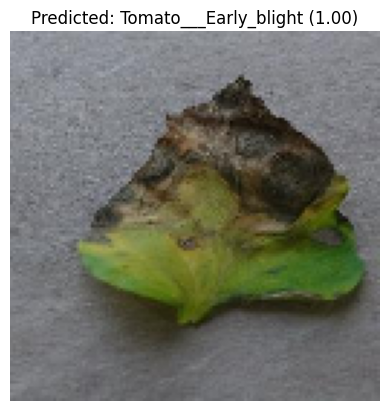

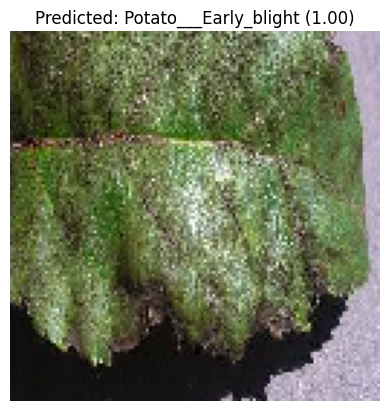

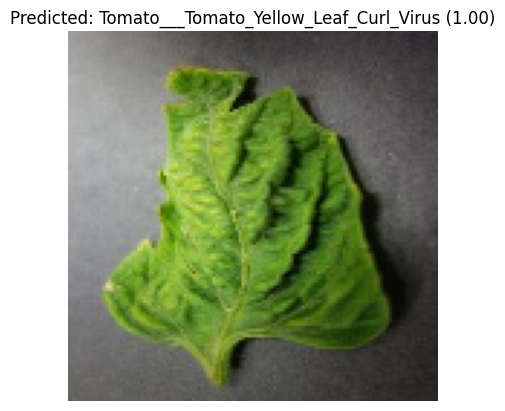

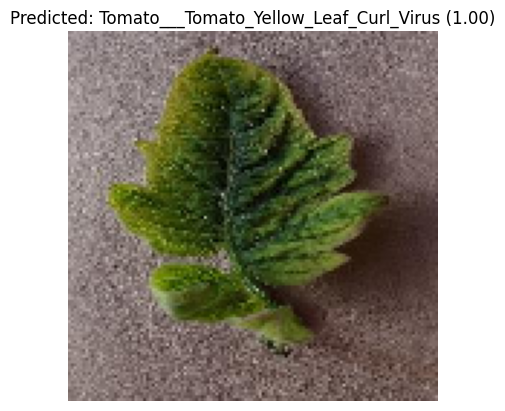

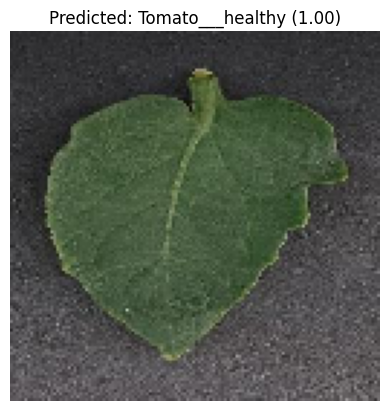

In [12]:
# =========================================================
# STEP 1: Load Required Libraries
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# =========================================================
# STEP 2: Load Model
# =========================================================
model_path = "/content/plant_disease_cnn.h5"  # update if different
model = load_model(model_path)
print("✅ Model loaded successfully.")

# =========================================================
# STEP 3: Define Test Directory
# =========================================================
test_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/test/test"
test_images = os.listdir(test_dir)
print(f"Found {len(test_images)} test images.")

# =========================================================
# STEP 4: Get Class Labels (from training generator)
# =========================================================
# If you saved the class indices earlier, load them.
# Otherwise, rebuild using your train directory structure.
train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

# Reverse mapping: index → class name
class_indices = {v: k for k, v in train_gen.class_indices.items()}

# =========================================================
# STEP 5: Predict on Test Images
# =========================================================
predictions = []

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)

    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)
    predicted_class_idx = np.argmax(pred, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_idx]
    confidence = np.max(pred)

    predictions.append([img_name, predicted_class_name, confidence])

# =========================================================
# STEP 6: Save Predictions to CSV
# =========================================================
results_df = pd.DataFrame(predictions, columns=["Image", "Predicted_Class", "Confidence"])
results_df.to_csv("test_predictions.csv", index=False)
print("✅ Predictions saved to test_predictions.csv")

# =========================================================
# STEP 7: Show Sample Predictions
# =========================================================
for i in range(5):
    img_name, label, conf = predictions[i]
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(128,128))
    plt.imshow(img)
    plt.title(f"Predicted: {label} ({conf:.2f})")
    plt.axis("off")
    plt.show()


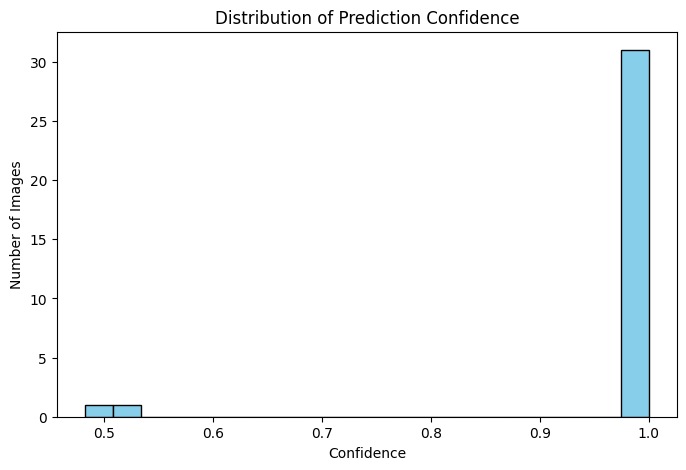

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions CSV
df = pd.read_csv("test_predictions.csv")

# Histogram of confidence
plt.figure(figsize=(8,5))
plt.hist(df['Confidence'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Confidence")
plt.xlabel("Confidence")
plt.ylabel("Number of Images")
plt.show()


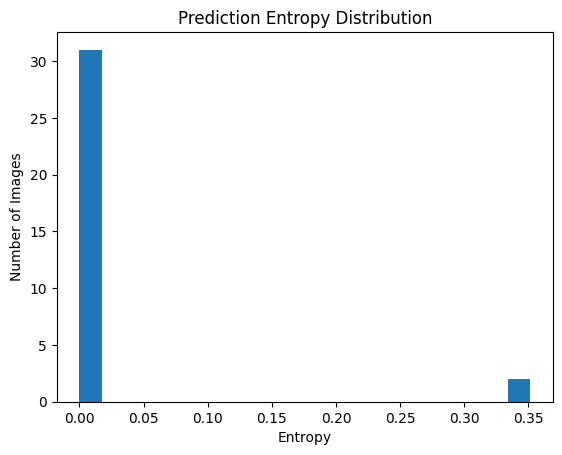

In [14]:
import scipy.stats

df['Entropy'] = df['Confidence'].apply(lambda x: -np.sum(x*np.log(x + 1e-7)))
plt.hist(df['Entropy'], bins=20)
plt.title("Prediction Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Number of Images")
plt.show()


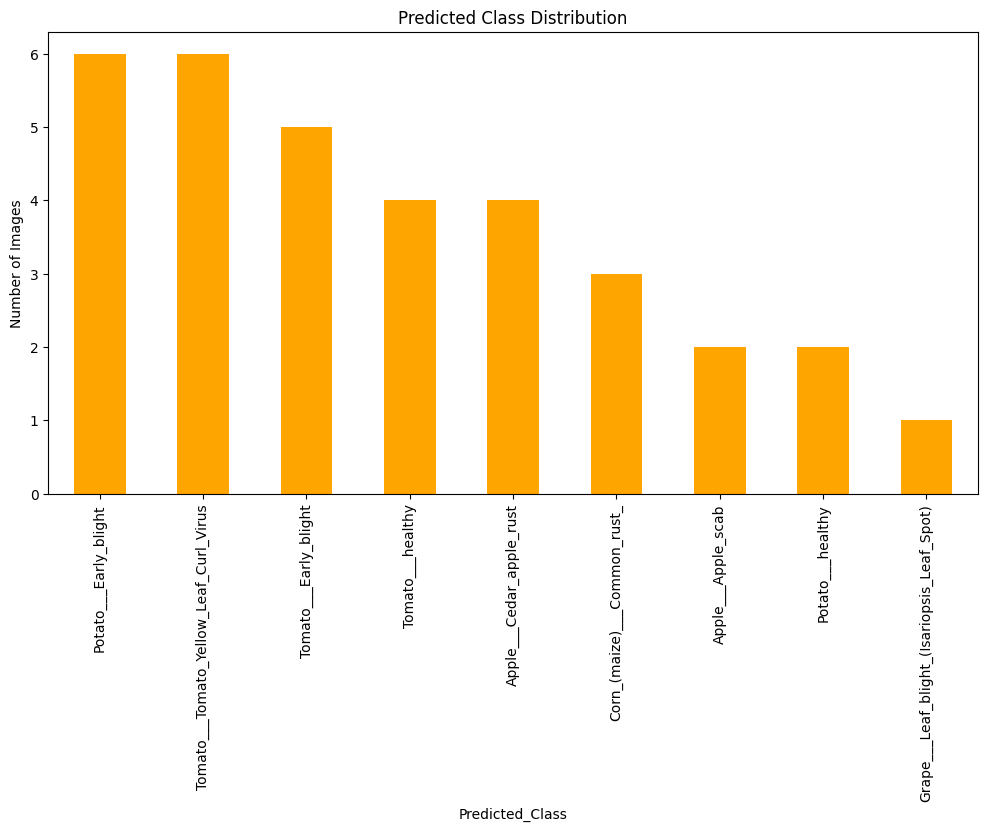

In [15]:
df['Predicted_Class'].value_counts().plot(kind='bar', figsize=(12,6), color='orange')
plt.title("Predicted Class Distribution")
plt.ylabel("Number of Images")
plt.show()


In [16]:
low_confidence = df[df['Confidence'] < 0.7]
print("Low-confidence predictions:")
print(low_confidence)


Low-confidence predictions:
                     Image           Predicted_Class  Confidence   Entropy
9      AppleCedarRust1.JPG  Apple___Cedar_apple_rust    0.482928  0.351517
26  TomatoEarlyBlight6.JPG     Tomato___Early_blight    0.520873  0.339739


In [ ]:
# =========================================================
# STEP 1: Import Libraries
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# =========================================================
# STEP 2: Load Model
# =========================================================
model_path = "/content/drive/MyDrive/plant_disease_cnn.h5"
model = load_model(model_path)
print(" Model loaded.")

# =========================================================
# STEP 3: Load Test Labels
# =========================================================
test_dir = "/content/drive/MyDrive/PlantVillage_Split/test"
test_csv = "/content/drive/MyDrive/PlantVillage_Split/test_labels.csv"
df_test = pd.read_csv(test_csv)
print(f"Found {len(df_test)} labeled test images.")

# Get class names
class_names = sorted(df_test['Label'].unique())
class_to_idx = {cls:i for i, cls in enumerate(class_names)}
idx_to_class = {i:cls for cls, i in class_to_idx.items()}

# =========================================================
# STEP 4: Predict on Test Images
# =========================================================
y_true = []
y_pred = []
y_conf = []

for _, row in df_test.iterrows():
    img_name = row['Image']
    label = row['Label']
    img_path = os.path.join(test_dir, label, img_name)

    # Load image
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred_prob = model.predict(img_array)
    pred_idx = np.argmax(pred_prob, axis=1)[0]
    pred_class = idx_to_class[pred_idx]
    confidence = np.max(pred_prob)

    # Save
    y_true.append(class_to_idx[label])
    y_pred.append(pred_idx)
    y_conf.append(confidence)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_conf = np.array(y_conf)

# =========================================================
# STEP 5: Compute Metrics
# =========================================================
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
avg_confidence = np.mean(y_conf)

print(" Test Set Metrics:")
print(f"Accuracy:        {accuracy:.4f}")
print(f"Precision:       {precision:.4f}")
print(f"Recall:          {recall:.4f}")
print(f"F1-Score:        {f1:.4f}")
print(f"Average Confidence: {avg_confidence:.4f}")

# =========================================================
# STEP 6: Confusion Matrix
# =========================================================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# =========================================================
# STEP 7: Classification Report
# =========================================================
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

# =========================================================
# STEP 8: Confidence Distribution
# =========================================================
plt.figure(figsize=(8,5))
plt.hist(y_conf, bins=20, color='skyblue', edgecolor='black')
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Number of Images")
plt.show()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/plant_disease_cnn.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)